# Imports

In [1]:
from spectral import imshow, view_cube
import spectral.io.envi as envi
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from scipy.optimize import curve_fit
from scipy.optimize import least_squares
from sklearn.linear_model import LinearRegression
from numpy.polynomial import Polynomial, polynomial
import time
from tqdm.notebook import tqdm

# https://doi.org/10.1063/5.0019847 imports
import algorithm.generate_spectrum as gs
from algorithm.pixel_operations import choose_pixels, generate_combinations
from algorithm.temperature_functions import optimum_temperature
from algorithm.kfold import order_selection
from scipy.interpolate import splrep, splev, UnivariateSpline

# constants
h = 6.626e-34 # Planck's constant
c = 299792458 # Speed of light
k = 1.380649e-23 # Boltzmann constant
b = 2.89777e-3 # Wien's displacement law constant

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


# Opening Data

In [2]:
# opening the raw data from its ENVI file and header
dark_ref = envi.open('graphite_rod_2/darkReference.hdr', 'graphite_rod_2/darkReference.raw')
white_ref = envi.open('graphite_rod_2/whiteReference.hdr', 'graphite_rod_2/whiteReference.raw')
data_ref = envi.open('graphite_rod_2/raw.hdr', 'graphite_rod_2/raw.raw')

# converting the data to a tensor as a NumPy array
white_tensor = np.array(white_ref.load())
dark_tensor = np.array(dark_ref.load())
data_tensor = np.array(data_ref.load())

# correcting tensor with references and displaying tensor as an image
corrected_data = np.divide(
    np.subtract(data_tensor, dark_tensor),
    np.subtract(white_tensor, dark_tensor))

/Users/namanparikh/opt/anaconda3/envs/hyperspectral/lib/python3.9/site-packages/spectral/graphics/spypylab.py:796: UserWarning: Failed to create RectangleSelector object. Interactive pixel class labeling will be unavailable.
  warnings.warn(msg)


<Figure size 640x480 with 0 Axes>

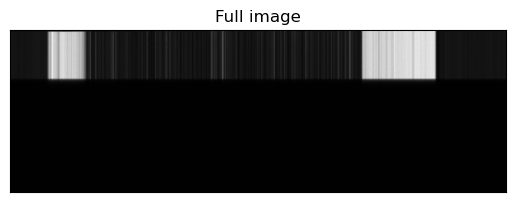

<Figure size 640x480 with 0 Axes>

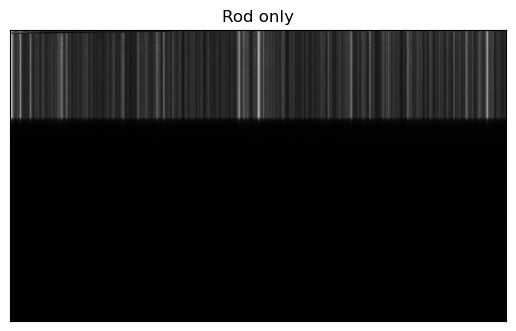

<Figure size 640x480 with 0 Axes>

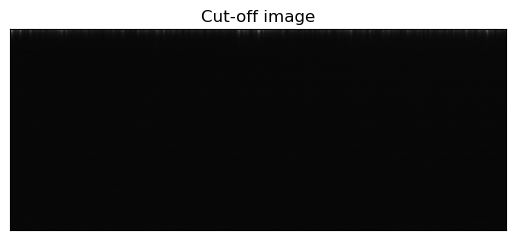

In [3]:
# displaying data
plt.figure()
imshow(corrected_data, (100,100,100))
plt.title("Full image")
plt.xticks([])
plt.yticks([])
plt.show()

# displaying data
plt.figure()
imshow(corrected_data[:,240:1130,:], (100,100,100))
plt.title("Rod only")
plt.xticks([])
plt.yticks([])
plt.show()

cut_data = corrected_data[163:,240:1130:,:]
plt.figure()
imshow(cut_data, (100,100,100))
plt.title("Cut-off image")
plt.xticks([])
plt.yticks([])
plt.show()

In [4]:
# reading hdr file
file = open("raw.hdr", 'r')
text = file.read()

# parsing for wavelength values and units
start_id = "\nwavelength = {\n"
start_index = text.find(start_id) + len(start_id)
end_id = "\n}\n;AOI height"
end_index = text.find(end_id)
wavelengths = text[start_index:end_index]
wavelengths = np.array(wavelengths.split("\n,"), dtype="float32")
units_id = "wavelength units = "
units_index = text.find(units_id) + len(units_id)
units = text[units_index:text.find(start_id)]
# print(f"Units = {units}")
# print(f"Number wavelengths = {len(wavelengths_arr)}")
# print(f"Wavelengths: {wavelengths_arr}")

# Pyrometry Setup

In [5]:
# l: wavelength, T: temperature, e: emissivity, offset: constant offset to account for stray light in the data
def blackbody(l, T, e, offset):
    return (e * ((2 * h * c**2) / l**5) * (1 / (np.exp((h * c) / (l * k * T)) - 1))) + offset

def quiet_fit(wl, data, intensity, params0):
    
    def residuals(params):
        result = []
        for i in range(len(wl)):
            Si = intensity(params, wl[i] * 1e-9)
            St = data[i]
            result.append(Si - St)
        return np.array(result)

    result = least_squares(residuals, params0)
    return result

# Averaging Every 10 Frames

## Averaging Spectrum

In [6]:
def compress(data, slice_len):
    retval = []
    for iter in range(data.shape[0] // slice_len):
        start_idx = iter * slice_len
        end_idx = (iter + 1) * slice_len
        retval.append(np.divide(sum(data[start_idx:end_idx]), slice_len))
    return np.array(retval)

In [7]:
compressed_data = compress(cut_data, 10)

### Position 0

In [8]:
row = compressed_data[:,0,:]
wl = wavelengths

  0%|          | 0/36 [00:00<?, ?it/s]

Fatal Python error: config_get_locale_encoding: failed to get the locale encoding: nl_langinfo(CODESET) failed
Python runtime state: preinitialized



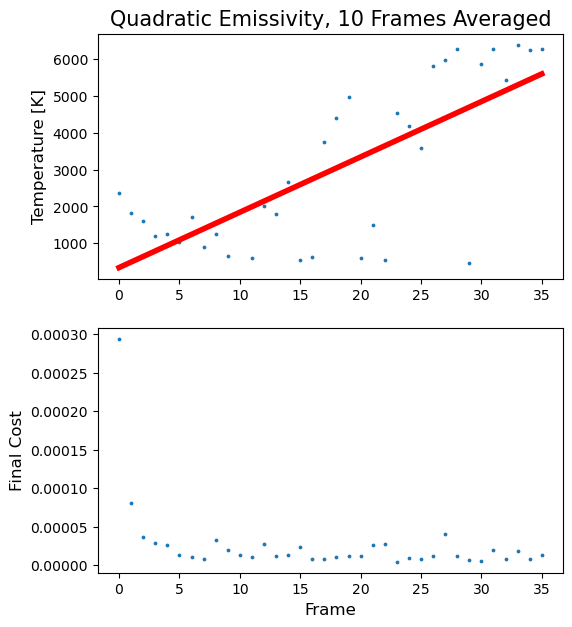

In [9]:
Ts = []
costs = []

for frame_index in tqdm(range(len(row))):
    data = row[frame_index]
    
    # params = [a0, a1, a2, offset, T]
    params0 = np.array([1, 1, 1, 0.1, 1000])
    def intensity(params, l):
        e = params[0] + (params[1] * l) + (params[2] * l**2)
        return blackbody(l, params[4], e, params[3])
    
    result = quiet_fit(wl, data, intensity, params0)
    Ts.append(result.x[-1]), costs.append(result.cost)

x = np.array(range(len(Ts)))
fig, ax = plt.subplots(nrows = 2, ncols = 1)
fig.set_figwidth(6)
fig.set_figheight(7)
ax[0].set_title("Quadratic Emissivity, 10 Frames Averaged", fontsize=15)

ax[0].scatter(x, Ts, s=3)
ax[0].set_ylabel("Temperature [K]", fontsize=12)
model = LinearRegression()
model.fit(x.reshape(-1,1), Ts)
ax[0].plot(x, model.predict(x.reshape(-1, 1)), color="red", linewidth=4)

ax[1].scatter(range(len(costs)), costs, s=3)
ax[1].set_ylabel("Final Cost", fontsize=12)

ax[1].set_xlabel("Frame", fontsize=12)

plt.show()

### Position 400

In [26]:
row = compressed_data[:,400,:]
wl = wavelengths

  0%|          | 0/36 [00:00<?, ?it/s]

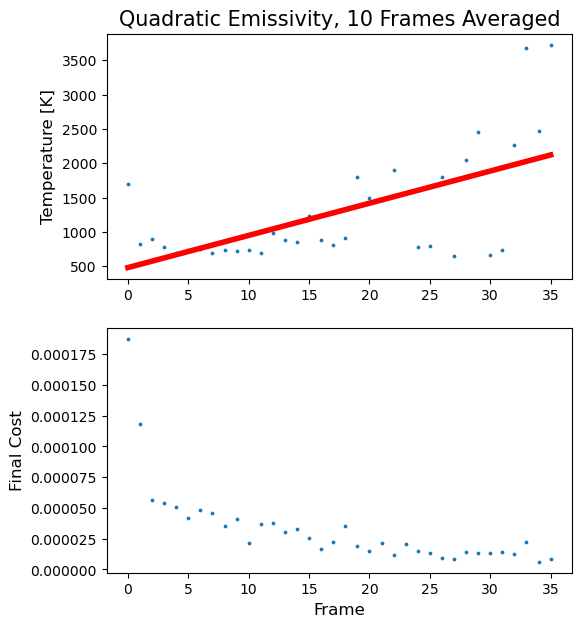

In [27]:
Ts = []
costs = []

for frame_index in tqdm(range(len(row))):
    data = row[frame_index]
    
    # params = [a0, a1, a2, offset, T]
    params0 = np.array([1, 1, 1, 0.1, 1000])
    def intensity(params, l):
        e = params[0] + (params[1] * l) + (params[2] * l**2)
        return blackbody(l, params[4], e, params[3])
    
    result = quiet_fit(wl, data, intensity, params0)
    Ts.append(result.x[-1]), costs.append(result.cost)

x = np.array(range(len(Ts)))
fig, ax = plt.subplots(nrows = 2, ncols = 1)
fig.set_figwidth(6)
fig.set_figheight(7)
ax[0].set_title("Quadratic Emissivity, 10 Frames Averaged", fontsize=15)

ax[0].scatter(x, Ts, s=3)
ax[0].set_ylabel("Temperature [K]", fontsize=12)
model = LinearRegression()
model.fit(x.reshape(-1,1), Ts)
ax[0].plot(x, model.predict(x.reshape(-1, 1)), color="red", linewidth=4)

ax[1].scatter(range(len(costs)), costs, s=3)
ax[1].set_ylabel("Final Cost", fontsize=12)

ax[1].set_xlabel("Frame", fontsize=12)

plt.show()

## Averaging Temps

### Position 0

In [15]:
row = cut_data[:,0,:]
wl = wavelengths

  0%|          | 0/360 [00:00<?, ?it/s]

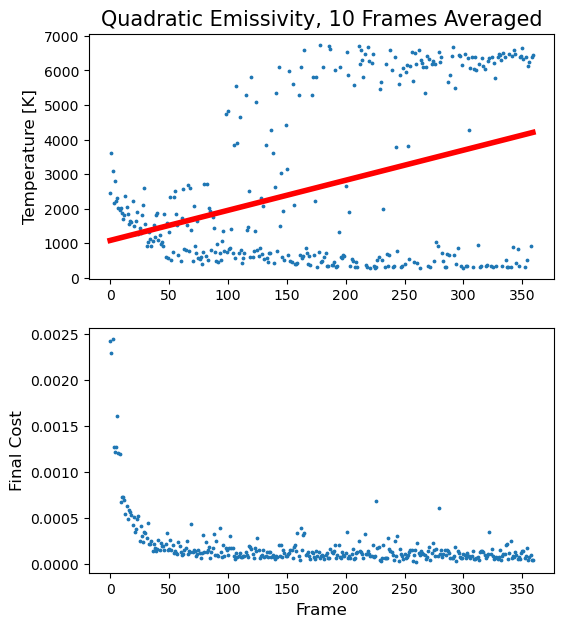

In [16]:
Ts = []
costs = []

for frame_index in tqdm(range(len(row))):
    data = row[frame_index]
    
    # params = [a0, a1, a2, offset, T]
    params0 = np.array([1, 1, 1, 0.1, 1000])
    def intensity(params, l):
        e = params[0] + (params[1] * l) + (params[2] * l**2)
        return blackbody(l, params[4], e, params[3])
    
    result = quiet_fit(wl, data, intensity, params0)
    Ts.append(result.x[-1]), costs.append(result.cost)

x = np.array(range(len(Ts)))
fig, ax = plt.subplots(nrows = 2, ncols = 1)
fig.set_figwidth(6)
fig.set_figheight(7)
ax[0].set_title("Quadratic Emissivity, 10 Frames Averaged", fontsize=15)

ax[0].scatter(x, Ts, s=3)
ax[0].set_ylabel("Temperature [K]", fontsize=12)
model = LinearRegression()
model.fit(x.reshape(-1,1), Ts)
ax[0].plot(x, model.predict(x.reshape(-1, 1)), color="red", linewidth=4)

ax[1].scatter(range(len(costs)), costs, s=3)
ax[1].set_ylabel("Final Cost", fontsize=12)

ax[1].set_xlabel("Frame", fontsize=12)

plt.show()

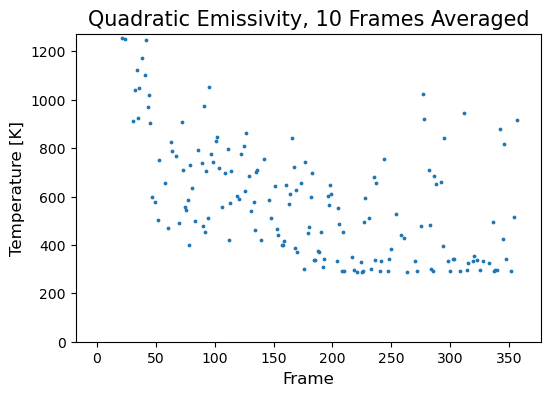

In [25]:
x = np.array(range(len(Ts)))
fig, ax = plt.subplots(nrows = 1, ncols = 1)
fig.set_figwidth(6)
fig.set_figheight(4)
ax.set_title("Quadratic Emissivity, 10 Frames Averaged", fontsize=15)

ax.scatter(x, Ts, s=3)
ax.set_ylabel("Temperature [K]", fontsize=12)
ax.set_ylim([0, 1273])
ax.set_xlabel("Frame", fontsize=12)

plt.show()

### Position 400

In [ ]:
row = cut_data[:,400,:]
wl = wavelengths

In [ ]:
Ts = []
costs = []

for frame_index in tqdm(range(len(row))):
    data = row[frame_index]
    
    # params = [a0, a1, a2, offset, T]
    params0 = np.array([1, 1, 1, 0.1, 1000])
    def intensity(params, l):
        e = params[0] + (params[1] * l) + (params[2] * l**2)
        return blackbody(l, params[4], e, params[3])
    
    result = quiet_fit(wl, data, intensity, params0)
    Ts.append(result.x[-1]), costs.append(result.cost)

x = np.array(range(len(Ts)))
fig, ax = plt.subplots(nrows = 2, ncols = 1)
fig.set_figwidth(6)
fig.set_figheight(7)
ax[0].set_title("Quadratic Emissivity, 10 Frames Averaged", fontsize=15)

ax[0].scatter(x, Ts, s=3)
ax[0].set_ylabel("Temperature [K]", fontsize=12)
model = LinearRegression()
model.fit(x.reshape(-1,1), Ts)
ax[0].plot(x, model.predict(x.reshape(-1, 1)), color="red", linewidth=4)

ax[1].scatter(range(len(costs)), costs, s=3)
ax[1].set_ylabel("Final Cost", fontsize=12)

ax[1].set_xlabel("Frame", fontsize=12)

plt.show()